In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
import random
import os

from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('ggplot')

In [32]:
#archivo que se va a leer para puntuar por cluster (carpeta ./recursos/)
archivoCSVLeido = 'conKMsVacio.csv'

#ponderaciones a la hora de puntuar el cluster
# mayor ponderacion = mayor importancia
ponderaciones = {
    'NumParadas': 0.2,
    'PorcentajePunto': 0.4,
    'Retraso': 0.8,
    'KmVacio': 0.6
}
n_clusters = 1000
#archivo que se va a generar en formato csv para el entrenamiento supervisado
archivoCSVGeneradoPuntuado = '1000gruposCluster.csv'

In [33]:
dataframe = pd.read_csv(r"./recursos/" + archivoCSVLeido)
dataframe.head()
#dataframe.describe()

,IDConductor,CodigoInternoPuntoCarga,LatitudPuntoCarga,LongitudPuntoCarga,CodigoInternoPuntoDescarga,LatitudPuntoDescarga,LongitudPuntoDescarga,NumParadas,PorcentajePunto,Retraso,KmVacio
0,Y4446672G,03,41.1996,1.2194,C115205,41.1535,1.2126,750,0.375333,31.541944,218
1,Y4446672G,03,41.1996,1.2194,C115205,41.1535,1.2126,750,0.375333,31.919444,128
2,46401708J,03,41.1996,1.2194,C115205,41.1535,1.2126,587,0.394714,32.299167,113
3,46401708J,03,41.1996,1.2194,C115205,41.1535,1.2126,587,0.394714,31.299167,135
4,52069433D,03,41.1996,1.2194,C115205,41.1535,1.2126,908,0.505234,-5.424722,209


In [34]:
scaler = StandardScaler()

X = scaler.fit_transform(
    dataframe.drop(['IDConductor', 'CodigoInternoPuntoCarga', 'LatitudPuntoCarga', 'LongitudPuntoCarga', 'CodigoInternoPuntoDescarga',
                    'LatitudPuntoDescarga', 'LongitudPuntoDescarga'], axis=1))
y = np.array(dataframe['IDConductor'])
X.shape

(153494, 4)

In [35]:
respuesta = input("Mostrar estadísticas de mejor numero de cluster (~3 min) (s/n): ")

if (respuesta == "s"):
    Nc = range(1, 182, 10)
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    kmeans
    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))] #codo de jambu
    score
    plt.plot(Nc,score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()

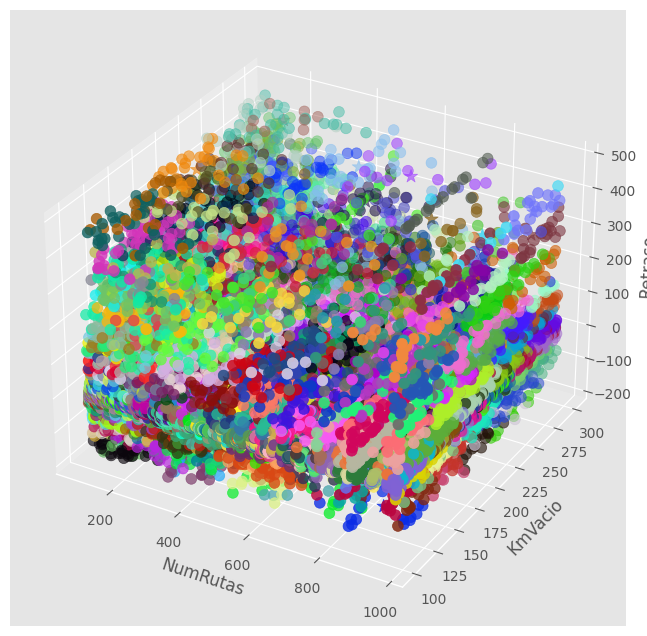

In [36]:
#calculo de loscentroides (en cada ejecucion pueden cambiar)
kmeans = KMeans(n_clusters=n_clusters, init='k-means++').fit(X)
centroids = kmeans.cluster_centers_
#print(centroids)

#Predict the clusters
labels = kmeans.predict(X)

# Getting the cluster centers
C = kmeans.cluster_centers_
# hasta 100
colores = ['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(n_clusters)]
colores = colores[:n_clusters]

asignar=[]
for row in labels:
    asignar.append(colores[row])


#unscale
X_restored = scaler.inverse_transform(X)
dataframe_escaled = pd.DataFrame(X, columns=dataframe.columns.drop(['IDConductor', 'CodigoInternoPuntoCarga', 
                                                                    'LatitudPuntoCarga', 'LongitudPuntoCarga', 'CodigoInternoPuntoDescarga',
                                                                    'LatitudPuntoDescarga', 'LongitudPuntoDescarga']))
C_unscaled = scaler.inverse_transform(C)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_restored[:, 0], X_restored[:, 3], X_restored[:, 2], c=asignar,s=60)
ax.scatter(C_unscaled[:, 0], C_unscaled[:, 3], C_unscaled[:, 2], marker='*', c=colores, s=100)
ax.set_xlabel('NumRutas')
ax.set_ylabel('KmVacio')
ax.set_zlabel('Retraso')
plt.show()

In [37]:
cluster_info = pd.DataFrame(columns=['Cluster', 'Feature', 'Min', 'Max', 'Mean', 'Median'])

#iterate over clusters
for cluster in range(n_clusters):
    cluster_subset = dataframe[labels == cluster]
    cluster_subset = cluster_subset.drop([
    'IDConductor', 'CodigoInternoPuntoCarga', 'LatitudPuntoCarga', 'LongitudPuntoCarga', 
    'CodigoInternoPuntoDescarga', 'LatitudPuntoDescarga', 'LongitudPuntoDescarga'], axis=1)
    
    for feature in cluster_subset.columns:
        feature_min = cluster_subset[feature].min()
        feature_max = cluster_subset[feature].max()
        feature_mean = cluster_subset[feature].mean()
        feature_median = cluster_subset[feature].median()
        new_row = pd.DataFrame({'Cluster': [cluster], 'Feature': [feature], 'Min': [feature_min], 'Max': [feature_max], 'Mean': [feature_mean], 'Median': [feature_median]})
        cluster_info = pd.concat([cluster_info, new_row], ignore_index=True)


cluster_info

C:\Users\pablo.gallardo\AppData\Local\Temp\ipykernel_13696\598250460.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_info = pd.concat([cluster_info, new_row], ignore_index=True)


,Cluster,Feature,Min,Max,Mean,Median
0,0,NumParadas,100,172,125.779018,125.000000
1,0,PorcentajePunto,0.469534,0.61435,0.520136,0.513201
2,0,Retraso,-12.390833,16.516944,0.398925,0.068333
3,0,KmVacio,158,180,169.165179,170.000000
4,1,NumParadas,218,403,292.951807,283.000000
...,...,...,...,...,...,...
3995,998,KmVacio,100,139,117.504202,117.000000
3996,999,NumParadas,100,222,146.550388,146.000000
3997,999,PorcentajePunto,0.232787,0.40625,0.316384,0.314961
3998,999,Retraso,13.391667,48.896389,27.336040,25.806667


### CLASIFICAR LOS CLUSTER Y PUNTUARLOS

In [38]:
maxNumParadas = dataframe['NumParadas'].max()
minNumParadas = dataframe['NumParadas'].min()
maxRetraso = dataframe['Retraso'].max()
minRetraso = dataframe['Retraso'].min()
maxKmVacio = dataframe['KmVacio'].max()
minKmVacio = dataframe['KmVacio'].min()
def obtenScore(NumRutas, porcentajePunto, retraso, kmVacio):
    NumRutasScore = obtenScoreNumRutas(NumRutas)
    porcentajePuntoScore = obtenScorePorcentajePunto(porcentajePunto)
    retrasoScore = obtenScoreRetraso(retraso)
    kmVacioScore = obtenScoreKmVacio(kmVacio)
    # print(numParadasScore, porcentajePuntoScore, retrasoScore, kmVacioScore)
    scoreTotal = ponderaciones['NumParadas'] * NumRutasScore + ponderaciones['PorcentajePunto'] * porcentajePuntoScore - ponderaciones['Retraso'] * retrasoScore - ponderaciones['KmVacio'] * kmVacioScore # el score es entre [-0.6, 0.4]
    return scoreTotal
def obtenScoreNumRutas(NumRutas):
    return ((NumRutas - minNumParadas) /  (maxNumParadas - minNumParadas))*100
def obtenScorePorcentajePunto(porcentajePunto):
    return (porcentajePunto * 100)
def obtenScoreRetraso(retraso):
    return ((retraso - minRetraso) / (maxRetraso - minRetraso))*100
def obtenScoreKmVacio(kmVacio):
    return ((kmVacio - minKmVacio) / (maxKmVacio - minKmVacio))*100

scores = [] # guarda una tupla (nombre_cluster, puntuacion)
i = 0
for cluster in cluster_info.groupby('Cluster'):
    features = []
    for feature in range (0, 4):
        features.append(cluster[1].get('Mean').values[feature])
    # print(features)
    cluster_name = "Cluster" +str(i)
    scores.append((cluster_name, obtenScore(features[0], features[1], features[2], features[3])))
    i+=1

print(scores)

#guardará una lista con los cluster ordenados y puntuados de 100 a 0, descendiente, dependiendo del numero de clusters
ordenados = sorted(scores, key=lambda x: x[1], reverse=True) 
pasoPuntuacion = 100 / len(ordenados) * -1
# print(pasoPuntuacion)
for puntuacion, i in zip(np.arange(100, 0, pasoPuntuacion), range(0, len(ordenados))):
    fila = ordenados[i]
    nuevaFila = fila + (puntuacion,)
    ordenados[i] = nuevaFila

ordenados

[('Cluster0', -20.765638217314535), ('Cluster1', -74.20542182728279), ('Cluster2', -10.550896629471588), ('Cluster3', -65.74700033194563), ('Cluster4', -24.729723098621438), ('Cluster5', -30.506728859401242), ('Cluster6', -51.4373841301974), ('Cluster7', -20.354698502625887), ('Cluster8', 18.480968286368466), ('Cluster9', -34.55688248252915), ('Cluster10', -24.720293137026225), ('Cluster11', -117.28643055879039), ('Cluster12', -53.63019567973642), ('Cluster13', -32.574750650336796), ('Cluster14', -64.49898636837098), ('Cluster15', -5.159185306721616), ('Cluster16', -19.447347548897447), ('Cluster17', -35.08731332435694), ('Cluster18', -17.59494947397254), ('Cluster19', -60.792464709191094), ('Cluster20', -64.29034384130313), ('Cluster21', -21.418032865206207), ('Cluster22', -30.649124224593038), ('Cluster23', -50.40367749428316), ('Cluster24', 13.095668931345738), ('Cluster25', -55.50044882362995), ('Cluster26', 12.133529677598137), ('Cluster27', -49.4332038868415), ('Cluster28', -17.7

[('Cluster378', 33.09782057586102, 100.0),
 ('Cluster193', 31.145692293011464, 99.9),
 ('Cluster296', 26.66894173115059, 99.80000000000001),
 ('Cluster553', 25.640344277537693, 99.70000000000002),
 ('Cluster841', 25.433557725710237, 99.60000000000002),
 ('Cluster343', 25.353439379712682, 99.50000000000003),
 ('Cluster674', 24.096351204403245, 99.40000000000003),
 ('Cluster490', 23.802866260035838, 99.30000000000004),
 ('Cluster258', 23.621756209837244, 99.20000000000005),
 ('Cluster166', 22.329167751558607, 99.10000000000005),
 ('Cluster604', 22.113274495425927, 99.00000000000006),
 ('Cluster411', 21.145121241503656, 98.90000000000006),
 ('Cluster916', 21.01599341241025, 98.80000000000007),
 ('Cluster330', 19.94323330886054, 98.70000000000007),
 ('Cluster485', 18.918330408106115, 98.60000000000008),
 ('Cluster828', 18.67983686287588, 98.50000000000009),
 ('Cluster8', 18.480968286368466, 98.40000000000009),
 ('Cluster51', 16.67739086869405, 98.3000000000001),
 ('Cluster142', 16.57723430

In [40]:
copy = pd.DataFrame()
# Copia las columnas IDConductor, CodigoInternoParadaCarga, etc.
copy = dataframe[['IDConductor', 'CodigoInternoPuntoCarga', 'LatitudPuntoCarga', 'LongitudPuntoCarga', 
                'CodigoInternoPuntoDescarga', 'LatitudPuntoDescarga', 'LongitudPuntoDescarga', 
                'NumParadas', 'PorcentajePunto', 'Retraso', 'KmVacio']].copy()
copy['Cluster'] = labels

diccionario = {}
print(ordenados)
for fila in ordenados:
    numero_cluster = int(fila[0].replace('Cluster', ''))
    diccionario.setdefault(numero_cluster, fila[2])

diccionario

copy['Puntuacion'] = copy['Cluster'].map(diccionario)
copy


rutaArchivoGenerar = os.getcwd() + '/recursos/' + archivoCSVGeneradoPuntuado
print("Generando archivo " + rutaArchivoGenerar + " ...")
respuesta = input("¿Desea generar el archivo (y sobreescribir si existe)? (s/n): ")
if (respuesta == 's'):
    copy.to_csv(rutaArchivoGenerar, index=False)

[('Cluster378', 33.09782057586102, 100.0), ('Cluster193', 31.145692293011464, 99.9), ('Cluster296', 26.66894173115059, 99.80000000000001), ('Cluster553', 25.640344277537693, 99.70000000000002), ('Cluster841', 25.433557725710237, 99.60000000000002), ('Cluster343', 25.353439379712682, 99.50000000000003), ('Cluster674', 24.096351204403245, 99.40000000000003), ('Cluster490', 23.802866260035838, 99.30000000000004), ('Cluster258', 23.621756209837244, 99.20000000000005), ('Cluster166', 22.329167751558607, 99.10000000000005), ('Cluster604', 22.113274495425927, 99.00000000000006), ('Cluster411', 21.145121241503656, 98.90000000000006), ('Cluster916', 21.01599341241025, 98.80000000000007), ('Cluster330', 19.94323330886054, 98.70000000000007), ('Cluster485', 18.918330408106115, 98.60000000000008), ('Cluster828', 18.67983686287588, 98.50000000000009), ('Cluster8', 18.480968286368466, 98.40000000000009), ('Cluster51', 16.67739086869405, 98.3000000000001), ('Cluster142', 16.577234300738386, 98.200000